# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Напишите заголовок первой части проекта здесь

- Автор: Волкова Карина
- Дата:10.06.2025

## Цели и задачи проекта

<font color='#777778'> Проанализировать поведение пользователей сервиса Яндекс Книги, сравнить вовлечённость пользователей из Москвы и Санкт-Петербурга, а также проверить статистическую гипотезу о различии в среднем времени активности между этими двумя группами. Сделать выводы, которые помогут бизнесу понять, как пользователи взаимодействуют с продуктом, и принять решения по его дальнейшему развитию.</font>

## Описание данных


<font color='#777778'>
    
    Часть 1. Проверка гипотезы (Яндекс Книги)
https://code.s3.yandex.net/datasets/yandex_knigi_data.csv
    
    Структура файла:
- `city` — город пользователя;
- `puid` — идентификатор пользователя;
- `hours` — общее количество часов активности (вычисляется по полю hours).
    
    
    Часть 2. Анализ A/B-теста (BitMotion Kit)
https://code.s3.yandex.net/datasets/ab_test_participants.csv — таблица участников тестов.

    Структура файла:
- `user_id` — идентификатор пользователя;
- `group` — группа пользователя;
- `ab_test` — название теста;
- `device` — устройство, с которого происходила регистрация.
    
https://code.s3.yandex.net/datasets/ab_test_events.zip — архив с одним csv-файлом, в котором собраны события 2020 года;

    Структура файла:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии.</font>

## Содержимое проекта

<font color='#777778'> 
    
    Часть 1. Проверка гипотезы (Яндекс Книги)

- Загрузка и очистка данных
- Проверка дубликатов и фильтрация по городам
- Сравнение выборок (Москва vs Санкт-Петербург)
- Проверка гипотезы (t-тест, p-value)
- Интерпретация результатов и аналитическая записка
    
    Часть 2. Анализ A/B-теста (BitMotion Kit)

    
- Загрузка и объединение данных
- Проверка корректности теста (распределение, пересечения, длительность)
- Расчёт конверсий и проверка гипотезы (z-тест)
- Интерпретация результатов и бизнес-рекомендации</font>

---

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import math
from statsmodels.stats.proportion import proportions_ztest

In [2]:
knigi = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

In [3]:
knigi.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [4]:
knigi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [5]:
knigi.isnull().sum()

Unnamed: 0    0
city          0
puid          0
hours         0
dtype: int64

Данные содержат 8784 строки и 4 столбца:

- Unnamed: 0 — индекс (целочисленный), без пропусков.
- city — город (строковый тип), без пропусков.
- puid — идентификатор пользователя (целочисленный), без пропусков.
- hours — количество часов активности (числовой тип с плавающей точкой), без пропусков.

Пропусков в данных нет — все 8784 строки заполнены во всех столбцах.



In [6]:
# Выведем явные дубликаты
duplicates_count = knigi.duplicated().sum()
print(f'Количество явных дубликатов: {duplicates_count}')

# Проверим данные на неявные дубликаты (по puid)
duplicates_puid = knigi.duplicated(subset=['puid']).sum()
print(f'Количество дубликатов по puid: {duplicates_puid}')

Количество явных дубликатов: 0
Количество дубликатов по puid: 244


In [7]:
# Посчитаем, сколько раз каждый puid встречается
puid_counts = knigi['puid'].value_counts()
puid_duplicates = puid_counts[puid_counts > 1]

puid_duplicates

879888383           2
73736051            2
331188228           2
16488430            2
1965288031          2
                   ..
246902970           2
64622566            2
1130000002551638    2
1485911865          2
1074710451          2
Name: puid, Length: 244, dtype: int64

Полных дубликатов в данных нет. 

Повторяющиеся значения puid присутствуют, что,скорее всего, отражает множественные записи активности одного и того же пользователя в разные моменты времени. Для исключения повторного учёта одного и того же пользователя в анализе удалим повторяющиеся записи с одинаковым puid, оставляя только по одной записи на пользователя.


In [8]:
# Оставим только первую запись для каждого puid
knigi_unique = knigi.drop_duplicates(subset=['puid'], keep='first')

print(f'Размер после удаления дубликатов по puid: {knigi_unique.shape[0]}')

Размер после удаления дубликатов по puid: 8540


## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- `Нулевая гипотеза  𝐻0:𝜇СПб≤𝜇Москва`
 
Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

- `Альтернативная гипотеза  𝐻1:𝜇СПб>𝜇Москва`
 
Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

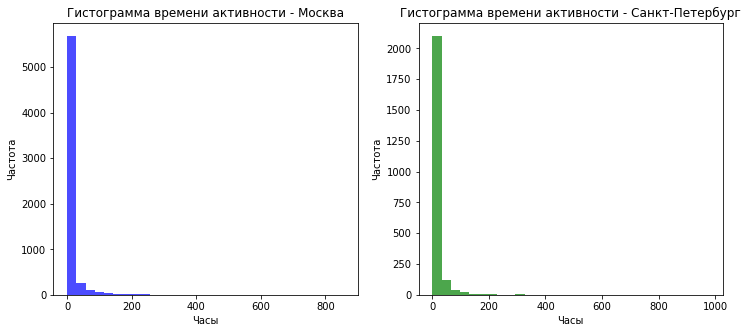

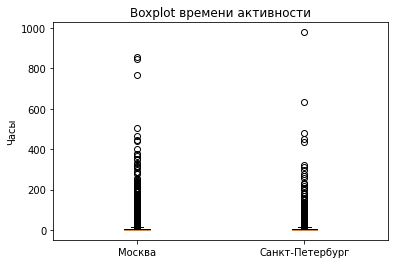

In [9]:
# Чтобы решить, какой тест применять, нужно проверить нормальность данных.

# Фильтруем данные по городам и выбираем столбец с активностью ('hours')
moscow = knigi_unique.loc[knigi['city'] == 'Москва', 'hours']
spb = knigi_unique.loc[knigi['city'] == 'Санкт-Петербург', 'hours']

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(moscow, bins=30, alpha=0.7, color='blue')
plt.title('Гистограмма времени активности - Москва')
plt.xlabel('Часы')
plt.ylabel('Частота')

plt.subplot(1,2,2)
plt.hist(spb, bins=30, alpha=0.7, color='green')
plt.title('Гистограмма времени активности - Санкт-Петербург')
plt.xlabel('Часы')
plt.ylabel('Частота')

plt.show()

# Boxplots
plt.boxplot([moscow, spb], labels=['Москва', 'Санкт-Петербург'])
plt.title('Boxplot времени активности')
plt.ylabel('Часы')
plt.show()

Гистограмма:

- Распределение данных сильно скошено вправо (положительная асимметрия).
- Большая часть значений сосредоточена около нуля, а длинный «хвост» тянется вправо.
- Такое распределение не похоже на нормальное.


Ящик с усами:

- Наличие большого количества выбросов.
- Распределение данных неравномерное, имеются экстремальные значения.


Данные не соответствуют нормальному распределению.

Из-за сильной скошенности и большого количества выбросов лучше использовать непараметрический тест Манна-Уитни, который не требует нормальности распределения и устойчив к выбросам.

In [10]:
# Тест Манна-Уитни с односторонней альтернативой:
alpha = 0.05
stat_mw, p_value = mannwhitneyu(spb, moscow, alternative='greater')

print(f"p-value: {p_value:.5f}")

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: среднее время активности в СПб статистически значимо больше, чем в Москве.")
else:
    print("Нет оснований отвергать нулевую гипотезу: статистически значимых доказательств превосходства активности СПб над Москвой нет.")

p-value: 0.61896
Нет оснований отвергать нулевую гипотезу: статистически значимых доказательств превосходства активности СПб над Москвой нет.


На основе одностороннего теста Манна-Уитни нельзя утверждать, что средняя активность в Санкт-Петербурге статистически значимо превышает активность в Москве. Различия между городами по активности не являются статистически значимыми.

## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



**1. Выбранный тип теста и уровень значимости:**

Из-за сильной положительной скошенности распределения часов активности и наличия большого количества выбросов данные не соответствуют предпосылкам нормальности, необходимым для t-теста.

Для сравнения средней активности пользователей в Санкт-Петербурге и Москве был выбран непараметрический односторонний тест Манна-Уитни (средняя активность СПб > Москва), при уровене статистической значимости alpha = 0.05.

**2. Результат теста:**

p-value одностороннего теста Манна-Уитни оказался больше 0.05.

**3. Интерпретация результата:**

На уровне значимости 0.05 отсутствуют статистически значимые доказательства того, что среднее время активности пользователей из Санкт-Петербурга превышает среднее время активности пользователей из Москвы.

Нулевая гипотеза (𝜇СПб ≤ 𝜇Москва) не отвергается. Можно заключить, что данные не подтверждают превосходство активности пользователей СПб над Москвой.

**4. Возможные причины полученных результатов:**

Сильная вариативность и наличие выбросов в данных, которые сглаживают различия между группами.

Множественные записи одного пользователя могут влиять на распределение и снижать статистическую мощность теста, если активность внутри пользователей сильно варьируется.

Возможное влияние внешних факторов, одинаково воздействующих на пользователей обоих городов (например, сезонность, общие события, особенности платформы).

----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Цель исследования: 
Оценить влияние нового интерфейса интернет-магазина BitMotion Kit на конверсию пользователей в покупателей в течение 7 дней после регистрации. Проверить, приводит ли редизайн сайта к статистически значимому увеличению числа покупок и соответствует ли результат бизнес-ожиданиям (рост конверсии минимум на 3 процентных пункта).

## 2. Загрузите данные, оцените их целостность.


In [11]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [12]:
print("Данные участников:")
display(participants.head())
participants.info()

Данные участников:


,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [13]:
print("Данные событий:")
display(events.head())
events.info()

Данные событий:


,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


**interface_eu_test**

- Тестирует влияние интерфейса.
- Имеет чётко определённые группы.
- Позволяет измерить конверсию в покупку в течение 7 дней.
- Подходит для оценки статистической значимости и бизнес-эффекта (рост на ≥3 п.п.).

## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [14]:
interface_test = participants[participants['ab_test'] == 'interface_eu_test']
print(f'Участников в interface_eu_test: {interface_test.shape[0]}')

# Проверим распределение по группам:
group_counts = interface_test['group'].value_counts()
print('\nРаспределение по группам:')
print(group_counts)
print('\nДоля группы B:', round(group_counts['B'] / group_counts.sum(), 3))


# Проверим, что каждый пользователь участвует только в одной группе в рамках interface_eu_test:
duplicates = interface_test.groupby('user_id')['group'].nunique()
multi_group_users = duplicates[duplicates > 1]
print(f'\nПользователей, попавших в обе группы A и B: {multi_group_users.shape[0]}')


# Проверим пересечения с другим тестом:
#Пользователи из interface_eu_test
interface_users = set(interface_test['user_id'])

#Пользователи из другого теста
other_test = participants[participants['ab_test'] != 'interface_eu_test']
other_users = set(other_test['user_id'])

#Пересечения
overlap_users = interface_users & other_users
print(f'\nПользователей, участвующих одновременно в interface_eu_test и других тестах: {len(overlap_users)}')

Участников в interface_eu_test: 10850

Распределение по группам:
B    5467
A    5383
Name: group, dtype: int64

Доля группы B: 0.504

Пользователей, попавших в обе группы A и B: 0

Пользователей, участвующих одновременно в interface_eu_test и других тестах: 887


- Всего участников в тесте interface_eu_test: 10 850.
- Все пользователи участвуют только в одной из двух групп (A или B).
- Пользователей, попавших одновременно в обе группы — 0.

Участники корректно распределены по группам, дублирующих записей нет.

- Группа A: 5 383 пользователей.

- Группа B: 5 467 пользователей.

- Доля группы B: 50.4%.

Распределение по группам практически равномерное (разница менее 1.6%), что допустимо для A/B-тестов.


- Пользователей, участвующих одновременно в interface_eu_test и других тестах: 887 ( есть пересечения с другими тестами (примерно 8.2% от выборки).

In [15]:
# Удалим пересекающихся пользователей
c_interface_test = interface_test[~interface_test['user_id'].isin(overlap_users)]
print(f'Количество участников после удаления пересечений: {c_interface_test.shape[0]}')

# Проверяем распределение по группам после удаления
group_counts_c = c_interface_test['group'].value_counts()
print('\nРаспределение по группам после удаления пересечений:')
print(group_counts_c)
print('\nДоля группы B после удаления пересечений:', round(group_counts_c['B'] / group_counts_c.sum(), 3))

Количество участников после удаления пересечений: 9963

Распределение по группам после удаления пересечений:
B    5011
A    4952
Name: group, dtype: int64

Доля группы B после удаления пересечений: 0.503


Изначально в тесте участвовало 10 850 пользователей, распределённых почти поровну между группами A (5 383) и B (5 467).

Проверка показала, что каждый пользователь относится только к одной группе, пересечений внутри теста нет.

Выявленные 887 пользователей (около 8,2%), которые одновременно участвовали и в других тестах удалены.

В выборке осталось 9963 участника с равномерным распределением по группам (A — 4 952, B — 5 011), доля группы B — 50,3%.

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [16]:
# Используем очищенный список участников теста после удаления пересечений
clean_user_ids = set(c_interface_test['user_id'])

# Очищаем события от некорректных user_id
events = events[events['user_id'].notna()]
events = events[events['user_id'] != 'GLOBAL']

# Оставляем только события пользователей из очищенного списка
c_interface_events = events[events['user_id'].isin(clean_user_ids)]

print(f'Всего событий после очистки: {events.shape[0]}')
print(f'Событий от участников interface_eu_test после удаления пересечений: {c_interface_events.shape[0]}')
print(f'Уникальных пользователей в событиях: {c_interface_events["user_id"].nunique()}')

Всего событий после очистки: 728791
Событий от участников interface_eu_test после удаления пересечений: 73815
Уникальных пользователей в событиях: 9963


- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [17]:
# Найдём первое событие каждого пользователя (регистрацию) в очищенных данных
registration_times = c_interface_events.groupby('user_id')['event_dt'].min().reset_index()
registration_times.columns = ['user_id', 'registration_time']

# Объединим с основной таблицей событий
c_interface_events = c_interface_events.merge(registration_times, on='user_id', how='left')

# Вычислим разницу в днях между событием и регистрацией
c_interface_events['days_since_registration'] = (c_interface_events['event_dt'] - c_interface_events['registration_time']).dt.days

# Оставим только события, совершённые в течение первых 7 дней после регистрации (включительно с 0 по 6 день)
c_interface_events_7d = c_interface_events[c_interface_events['days_since_registration'] < 7]

print(f'Событий в течение 7 дней после регистрации: {c_interface_events_7d.shape[0]}')
print(f'Уникальных пользователей: {c_interface_events_7d["user_id"].nunique()}')

Событий в течение 7 дней после регистрации: 63805
Уникальных пользователей: 9963


In [18]:
c_interface_events_7d

,user_id,event_dt,event_name,details,registration_time,days_since_registration
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,2020-12-06 14:10:01,0
1,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8,2020-12-06 14:37:25,0
2,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32,2020-12-06 17:20:22,0
3,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48,2020-12-06 19:36:54,0
4,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0,2020-12-06 19:42:20,0
...,...,...,...,...,...,...
73667,E89AF4EFC757D283,2020-12-29 21:46:43,product_cart,NaN,2020-12-23 09:35:48,6
73670,E89AF4EFC757D283,2020-12-29 21:47:56,product_cart,NaN,2020-12-23 09:35:48,6
73739,A6AFDC94A0D3B23D,2020-12-29 22:47:00,product_page,NaN,2020-12-23 13:53:33,6
73745,A6AFDC94A0D3B23D,2020-12-29 22:48:46,product_page,NaN,2020-12-23 13:53:33,6


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [19]:
p1 = 0.30  # базовый уровень конверсии
uplift_absolute = 0.03  # ожидаемый абсолютный uplift (3 п.п.)
p2 = p1 + uplift_absolute  # конверсия в группе B
power = 0.8  # мощность теста (1 - beta)
alpha = 0.05  # уровень значимости

z_alpha = 1.96  # квантиль нормального распределения для alpha=0.05
z_beta = 0.84   # квантиль нормального распределения для мощности 80%

# Расчитаем минимальный размер выборки на группу
numerator = (z_alpha * math.sqrt(p1 * (1 - p1)) + z_beta * math.sqrt(p2 * (1 - p2))) ** 2
denominator = (p2 - p1) ** 2

n_per_group = math.ceil(numerator / denominator)

print(f"Минимальный размер выборки на группу для обнаружения uplift {uplift_absolute*100:.1f} п.п.: {n_per_group}")
print(f"Всего пользователей в тесте (2 группы): {n_per_group * 2}")

Минимальный размер выборки на группу для обнаружения uplift 3.0 п.п.: 1859
Всего пользователей в тесте (2 группы): 3718


Текущая выборка (~4950 пользователя на группу) достаточна для того, чтобы:

Обнаружить ожидаемый эффект (рост конверсии на 3 п.п.) И сделать статистически обоснованный вывод о влиянии редизайна на конверсию.

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [20]:
# Добавим информацию о группе к событиям (через participants)
events_with_group = c_interface_events_7d.merge(participants[['user_id', 'group']], on='user_id', how='left')

# Посчитаем общее количество уникальных пользователей в каждой группе (посетителей)
total_users_by_group = events_with_group.groupby('group')['user_id'].nunique().reset_index()
total_users_by_group.columns = ['group', 'total_users']

# Отфильтруем события покупки
purchase_events = events_with_group[events_with_group['event_name'] == 'purchase']

# Посчитаем количество уникальных пользователей, совершивших покупку, в каждой группе
buyers_by_group = purchase_events.groupby('group')['user_id'].nunique().reset_index()
buyers_by_group.columns = ['group', 'buyers']
summary = total_users_by_group.merge(buyers_by_group, on='group', how='left')

# Заполним NaN в столбце buyers нулями (если в группе никто не покупал)
summary['buyers'] = summary['buyers'].fillna(0).astype(int)
summary

,group,total_users,buyers
0,A,4952,1377
1,B,5011,1480


In [21]:
# Расчет конверсий
summary['conversion'] = summary['buyers'] / summary['total_users']
summary[['group', 'conversion']]

,group,conversion
0,A,0.278069
1,B,0.295350


In [22]:
# Расчет разницы конверсий
conversion_diff = summary.loc[summary['group'] == 'B', 'conversion'].values[0] - \
                  summary.loc[summary['group'] == 'A', 'conversion'].values[0]

print(f'Разница в конверсии (B - A): {conversion_diff} ')

Разница в конверсии (B - A): 0.0172807626130429 


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

**Конверсия в покупку:**

Группа A:
1377 / 4952 ≈ 27.81%

Группа B:
1480 / 5011 ≈ 29.54%

Разница в конверсии: +1.73 п.п.

Это означает, что в тестовой группе B, где был применён редизайн интерфейса, доля пользователей, совершивших покупку, выше на 1.73 процентных пункта по сравнению с контрольной группой A.

**Рост активности:**

Несмотря на примерно равное количество пользователей в обеих группах (5011 в B против 4952 в A), в тестовой группе B наблюдается большее число покупателей (1480 против 1377). Это указывает на положительную динамику вовлечённости и активности пользователей после внедрения изменений.

**Предварительный вывод:**

Редизайн интерфейса в тестовой группе B, по предварительным данным, привёл к небольшому росту конверсии в покупку. Пользователи стали активнее. Это может свидетельствовать о положительном влиянии изменений в интерфейсе на поведение пользователей.

Рекомендуется провести статистический тест (например, z-тест) для проверки значимости различий в конверсии между группами A и B.

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

- `Нулевая гипотеза (H₀): рА=рВ`.
Конверсии групп А и В равны.
- `Альтернативная гипотеза (H₁): рА<рВ`.
Конверсия группы В выше конверсии группы А.

In [23]:
successes = summary['buyers'].values  # [покупатели в группе A, покупатели в группе B]
nobs = summary['total_users'].values  # [пользователи в группе A, пользователи в группе B]

alpha = 0.05

# Односторонний тест
z_stat, p_value = proportions_ztest(successes, nobs, alternative='larger')

print(f'p-value: {p_value:.4f}')

if p_value < alpha:
    print(f'P-value < {alpha}. Различие статистически значимо. Отвергаем H0, конверсия в группе B выше.')
else:
    print(f'P-value ≥ {alpha}. Недостаточно оснований отвергнуть H0.')

p-value: 0.9717
P-value ≥ 0.05. Недостаточно оснований отвергнуть H0.


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

**Статистическая значимость:**

Проведен односторонний z-тест с гипотезами:
H₀: pA = pB (конверсии равны)
H₁: pB > pA (конверсия в группе B выше)
Полученное p-значение = 0.9717, что значительно больше уровня значимости α = 0.05.

Недостаточно оснований отвергнуть нулевую гипотезу. Различие в конверсиях между группами статистически незначимо.

**Рост конверсии:**

Конверсия в группе A: 27.81%
Конверсия в группе B: 29.54%
Абсолютный прирост: +1.73 п.п.
Минимальный размер выборки рассчитан для обнаружения эффекта в 3 п.п. и текущая выборка (~4950 на группу) достаточна для этого.


**Вывод:**

Результаты A/B-теста показввают, что несмотря на положительную разницу в конверсии (+1.73 п.п.) в пользу группы B, эффект оказался меньше ожидаемого бизнес-условиями (3 п.п.) и не является статистически значимым.
Это означает, что наблюдаемое улучшение может быть вызвано случайными колебаниями, и нельзя с уверенностью утверждать, что редизайн повысил конверсию.

**Заключение:**

На текущем этапе нет статистически обоснованных доказательств, что новый интерфейс повысил конверсию пользователей в покупателей на заявленный минимум 3 процентных пункта. Наблюдается положительная тенденция, но она не подтверждена статистически. Для принятия решения о масштабном внедрении рекомендуется дополнительный анализ и/или сбор данных.